# Data prep

In [32]:
import os
path = "/Users/adi/Documents/University/YEAR 4/FYP thesis/Panonut360/dataset/"

In [135]:
import pandas as pd
import os

def load_all_data(base_dir):
    """
    Loads and consolidates data from multiple CSV files into a single DataFrame.
    
    Parameters:
        base_dir (str): The base directory containing subdirectories for each video, 
                        with CSV files for each user.
    
    Returns:
        DataFrame: A consolidated DataFrame containing data from all videos and users.
    """
    # Define an empty list to collect data from each CSV file
    all_data = []
    
    # Loop through each video directory
    for video_id in range(13, 14):  # Assuming video IDs are numbered from 1 to 15
        video_dir = os.path.join(base_dir, f"video_{video_id}")
        
        # Loop through each user's CSV file within the video directory
        for user_id in range(1, 11):  # Assuming user IDs are numbered from 1 to 50
            file_path = os.path.join(video_dir, f"user{user_id}.csv")

        
            
            # Check if the file exists to avoid errors
            if os.path.isfile(file_path):
                # Load the CSV file and handle the PlayerTime parsing
                df = pd.read_csv(file_path)

                df['video_ID'] = video_id
                df['user_ID'] = user_id
                
                # Ensure PlayerTime column has the correct format by trimming whitespace
                df['player_time'] = df['player_time'].str.strip()
                
                # Convert PlayerTime to datetime format
                try:
                    df['player_time'] = pd.to_timedelta(df['player_time'])
                    # df['player_time'] = pd.to_datetime(df['player_time'], format='%H:%M:%S.%f').dt.time
                except ValueError as e:
                    print(f"Error parsing time in file {file_path}: {e}")
                    continue  # Skip this file if there’s an error

                # Calculate elapsed time
                df['Elapsed_Time'] = (df['player_time'] - df['player_time'].iloc[0]).dt.total_seconds()
                
                
                # Append the processed DataFrame to the list
                all_data.append(df)
    
    # Concatenate all data into a single DataFrame
    consolidated_df = pd.concat(all_data, ignore_index=True)
    
    return consolidated_df


In [137]:
consolidated_data = load_all_data(path)

In [138]:
consolidated_data['user_ID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

<Axes: >

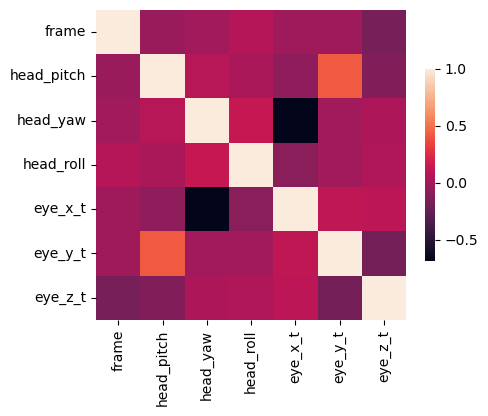

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
features1 = ['head_x', 'head_y', 'head_z', 'eye_c_x', 'eye_c_y', 'eye_c_z', 'eye_x_t', 'eye_y_t', 'eye_z_t', 
            'head_pitch', 'head_yaw', 'head_roll', 'head_quaternion_w', 'head_quaternion_x', 
            'head_quaternion_y', 'head_quaternion_z', 'eye_quaternion_w', 'eye_quaternion_x', 
            'eye_quaternion_y', 'eye_quaternion_z']
features = ['frame','head_pitch', 'head_yaw', 'head_roll', 'eye_x_t', 'eye_y_t', 'eye_z_t']

co_matrix=consolidated_data[features].corr()
plt.figure(figsize=(5,5))
sns.heatmap(co_matrix, square=True, cbar_kws={"shrink": .5})

# LSTM model 

In [143]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, TimeDistributed, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure frame numbers are not normalized
features = ['head_pitch', 'head_yaw', 'head_roll', 'eye_x_t', 'eye_y_t', 'eye_z_t']

# Create a copy of the frame column for tracking
df = consolidated_data[:]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

df['frame'] = consolidated_data['frame']

# Group data by user
grouped_by_user = df.groupby('user_ID')

# Separate users into training and testing (80% train, 20% test)
user_ids = df['user_ID'].unique()
np.random.shuffle(user_ids)
train_users, test_users = train_test_split(user_ids, test_size=0.2, random_state=50)

# Create separate datasets for training and testing
train_data = df[df['user_ID'].isin(train_users)]
test_data = df[df['user_ID'].isin(test_users)]

sequence_length = 5  # Length of each sequence
n_frames_ahead = 10 # Predict 5 frames ahead

def create_sequences_with_multiple_targets(df, features, frame_column, sequence_length, n_frames_ahead):
    X, y, frames = [], [], []
    for i in range(len(df) - sequence_length - n_frames_ahead + 1):
        X.append(df[features].iloc[i:i + sequence_length].values)
        # Flatten the next n_frames_ahead targets
        y.append(df[features].iloc[i + sequence_length:i + sequence_length + n_frames_ahead].values.flatten())
        frames.append(df[frame_column].iloc[i + sequence_length:i + sequence_length + n_frames_ahead].values)
    return np.array(X), np.array(y), np.array(frames)

# X, y, frame_numbers = create_sequences_with_multiple_targets(df, features, 'frame', sequence_length, n_frames_ahead)

# Group train_data by user_ID
grouped_train = train_data.groupby('user_ID')

X_train, y_train, frame_train = [], [], []
for user_id, user_data in grouped_train:
    X_user, y_user, frames_user = create_sequences_with_multiple_targets(
        user_data, features, 'frame', sequence_length, n_frames_ahead
    )
    X_train.append(X_user)
    y_train.append(y_user)
    frame_train.append(frames_user)

# Group test_data by user_ID
grouped_test = test_data.groupby('user_ID')

X_test, y_test, frame_test = [], [], []
for user_id, user_data in grouped_test:
    X_user, y_user, frames_user = create_sequences_with_multiple_targets(
        user_data, features, 'frame', sequence_length, n_frames_ahead
    )
    X_test.append(X_user)
    y_test.append(y_user)
    frame_test.append(frames_user)

# Combine data for all users
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
frame_train = np.concatenate(frame_train, axis=0)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
frame_test = np.concatenate(frame_test, axis=0)

# Reshape X for ConvLSTM: (samples, time steps, rows, columns, channels)
# X = X.reshape((X.shape[0], sequence_length, 1, len(features), 1))
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1, len(features), 1))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, len(features), 1))

# # Split data into train and test sets (80-20 split)
# X_train, X_test, y_train, y_test, frame_train, frame_test = train_test_split(
#     X, y, frame_numbers, test_size=0.2, random_state=50
# )

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 3), padding="same", return_sequences=True, 
               input_shape=(sequence_length, 1, len(features), 1)),
    Dropout(0.5),
    ConvLSTM2D(filters=32, kernel_size=(1, 3), padding="same", return_sequences=False),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_frames_ahead * len(features))  # Output predicts n_frames_ahead
])

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train, epochs=50, batch_size=1, validation_split=0.1,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Predict on the test set
predictions = model.predict(X_test)

# # Reshape the predictions to (samples, n_frames_ahead, len(features))
predictions = predictions.reshape(-1, n_frames_ahead, len(features))
y_test_reshaped = y_test.reshape(-1, n_frames_ahead, len(features))

# Inverse transform to get the original scale for predictions
predictions = scaler.inverse_transform(predictions.reshape(-1, len(features)))
y_test_original = scaler.inverse_transform(y_test_reshaped.reshape(-1, len(features)))

# predictions = predictions.reshape(-1, n_frames_ahead, len(features))
# y_test_original = y_test_original.reshape(-1, n_frames_ahead, len(features))

# Display some results
# print("Sample Predictions for the next 5 frames (original scale):", predictions_original[:1])
# print("Actual Values for the next 5 frames (original scale):", y_test_original[:1])


Epoch 1/50


/Users/adi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


133159/133159 ━━━━━━━━━━━━━━━━━━━━ 559s 4ms/step - loss: 0.0140 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 2/50
133159/133159 ━━━━━━━━━━━━━━━━━━━━ 578s 4ms/step - loss: 0.0103 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 3/50
133159/133159 ━━━━━━━━━━━━━━━━━━━━ 547s 4ms/step - loss: 0.0104 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 4/50
133159/133159 ━━━━━━━━━━━━━━━━━━━━ 613s 5ms/step - loss: 0.0104 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 5/50
133151/133159 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
133159/133159 ━━━━━━━━━━━━━━━━━━━━ 606s 5ms/step - loss: 0.0105 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 6/50
133159/133159 ━━━━━━━━━━━━━━━━━━━━ 639s 5ms/step - loss: 0.0100 - val_loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 7/50
133159/133159 ━━━━━━━━━━━━━━━━━━━━ 808s 6ms/step - loss: 0.0101 - val_loss: 0.0098 - learning_rate: 5.0000e-04
Epoch 8/50
133159/133159 ━━━━━━━━━━━━━━

In [145]:
preds = pd.DataFrame({
    'frame' : frame_test.flatten(),
    'predicted_head_pitch': predictions[:, 0],
    'predicted_head_yaw': predictions[:, 1],
    'predicted_head_roll': predictions[:, 2],
    'predicted_eye_x_t': predictions[:, 3],
    'predicted_eye_y_t': predictions[:, 4],
    'predicted_eye_z_t': predictions[:, 5],
})
sorted_df = preds.sort_values(by=['frame'], ascending=True)
sorted_df[:]

,frame,predicted_head_pitch,predicted_head_yaw,predicted_head_roll,predicted_eye_x_t,predicted_eye_y_t,predicted_eye_z_t
216010,1,350.356689,144.318817,7.961588,-0.994913,-0.910182,-0.054794
216000,1,350.383392,144.775253,7.998838,-0.996870,-0.908083,-0.047078
216020,1,350.325104,144.068726,7.918887,-0.993831,-0.911553,-0.062744
216001,1,350.429321,145.300995,8.688401,-0.955155,-0.880236,-0.010654
216011,1,350.401550,144.844315,8.660120,-0.953155,-0.882122,-0.018230
...,...,...,...,...,...,...,...
411688,6164,344.284607,216.291794,19.790443,-0.601483,-0.118079,-0.677209
215999,6164,347.348145,291.870514,22.792263,-0.839545,-0.237705,0.177709
215989,6164,347.463806,292.165436,22.822861,-0.835030,-0.247031,0.182563
411679,6164,343.605316,216.873871,21.297802,-0.596817,-0.104221,-0.679198


In [147]:
orig = pd.DataFrame({
    'frame': frame_test.flatten(),
    'actual_head_pitch': y_test_original[:,0],
    'actual_head_yaw': y_test_original[:,1],
    'actual_head_roll': y_test_original[:,2],
    'actual_eye_x_t': y_test_original[:,3],
    'actual_eye_y_t': y_test_original[:,4],
    'actual_eye_z_t': y_test_original[:,5]# Use the frame numbers from the test set
})
sorted_df2 = orig.sort_values(by=['frame'], ascending=True)
sorted_df2

,frame,actual_head_pitch,actual_head_yaw,actual_head_roll,actual_eye_x_t,actual_eye_y_t,actual_eye_z_t
216010,1,354.5476,147.0262,3.982850,-1.388959,-1.018946,0.180397
216000,1,354.5975,147.4097,3.998456,-1.388425,-1.017867,0.190323
216020,1,354.5476,147.0262,3.982850,-1.388959,-1.018946,0.180397
216001,1,354.5476,147.0262,3.982850,-1.388959,-1.018946,0.180397
216011,1,354.5476,147.0262,3.982850,-1.388959,-1.018946,0.180397
...,...,...,...,...,...,...,...
411688,6164,352.8978,213.8044,4.405426,-0.479042,-0.017853,-0.877594
215999,6164,356.0146,283.2687,3.491027,-0.971664,-0.190786,0.139474
215989,6164,356.0146,283.2687,3.491027,-0.971664,-0.190786,0.139474
411679,6164,352.8978,213.8044,4.405426,-0.479042,-0.017853,-0.877594


In [149]:
from sklearn.metrics import r2_score
r_score = r2_score(y_test_original,predictions)
print(r_score)
fit_accuracy = r_score * 100
print(f"Fit Accuracy (R² as percentage): {fit_accuracy:.2f}%")

0.8072211847269105
Fit Accuracy (R² as percentage): 80.72%


In [143]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
pred = pd.DataFrame(predictions, columns =['head_pitch', 'head_yaw', 'head_roll','eye_x_t', 'eye_y_t', 'eye_z_t'])
orig = pd.DataFrame(y_test_original, columns =['head_pitch', 'head_yaw', 'head_roll','eye_x_t', 'eye_y_t', 'eye_z_t']) 
# print(pred[:5])
# print(orig[:5])
# print("Actual Values:", y_test_original[:5])

array([[343.253387, 209.361511, 3.463484, -0.492825, 0.223003, -0.833138],
       [353.088287, 124.217766, 5.107285, 0.765391, -0.019378, -0.626749],
       [353.481812, 164.549286, 3.391519, 0.295855, -0.022459, -0.953544],
       ...,
       [15.706190, 91.304749, 3.407899, 0.844138, -0.532841, -0.016338],
       [40.072292, 156.378845, 3.775212, 0.223483, -0.870453, -0.368895],
       [353.910492, 37.867886, 5.152746, 0.654437, -0.206351, 0.709923]],
      dtype=float32)

In [151]:
from sklearn.metrics import mean_squared_error
dense_mse1 = mean_squared_error(y_test_original[:], predictions[:])
print(f"Model MSE = {dense_mse1:.4f}")
import numpy as np 
MSE = np.square(np.subtract(y_test_original,predictions)).mean()
print(MSE)

Model MSE = 609.5339
609.533928707085


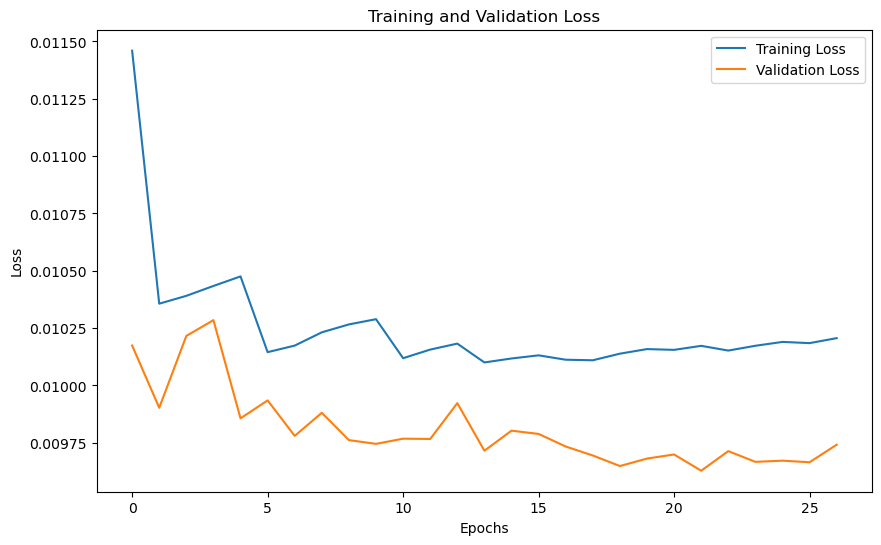

In [153]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Predicted FOV Calculation

In [162]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 19.1 MB/s eta 0:00:0000:0100:01


In [293]:
import cv2
import numpy as np
import pandas as pd
from math import sin, cos, radians



def overlay_hevc_tiles(frame, video_width, video_height, N_x, N_y):
    """
    Overlays the HEVC tile structure on a given video frame.
    Args:
        frame (np.ndarray): The video frame image.
        video_width (int): Width of the video in pixels.
        video_height (int): Height of the video in pixels.
        N_x (int): Number of tiles horizontally.
        N_y (int): Number of tiles vertically.
    Returns:
        np.ndarray: Frame with HEVC tile grid overlaid.
    """
    tile_width = video_width // N_x
    tile_height = video_height // N_y

    # Draw horizontal lines
    for i in range(1, N_y):
        y = i * tile_height
        cv2.line(frame, (0, y), (video_width, y), (255, 0, 0), 2)  # Blue grid lines

    # Draw vertical lines
    for j in range(1, N_x):
        x = j * tile_width
        cv2.line(frame, (x, 0), (x, video_height), (255, 0, 0), 2)  # Blue grid lines

    # Add tile indices
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(N_y):
        for j in range(N_x):
            x = j * tile_width + 10
            y = i * tile_height + 30
            cv2.putText(frame, f"Tile {i},{j}", (x, y), font, 0.5, (0, 0, 255), 1)  # Red text

    return frame







def calculate_fov_trig(head_pitch, head_yaw, eye_direction, video_width, video_height, fov_width=90, fov_height=90):
    """
    Calculate the optimal FOV on the 2D video plane based on head and gaze predictions
    using trigonometric calculations.

    Args:
        head_pitch (float): Predicted head pitch in degrees.
        head_yaw (float): Predicted head yaw in degrees.
        eye_direction (tuple): (eye_x, eye_y, eye_z) in 3D space (normalized vector).
        video_width (int): Width of the video in pixels.
        video_height (int): Height of the video in pixels.
        fov_width (int): Horizontal FOV in degrees (default 90°).
        fov_height (int): Vertical FOV in degrees (default 90°).

    Returns:
        tuple: (top_left, bottom_right) coordinates of the FOV on the video plane.
    """
    # Convert head_pitch and head_yaw from degrees to radians
    pitch_rad = radians(head_pitch)
    yaw_rad = radians(head_yaw)
    
    radius = 1.0

    # Convert spherical coordinates to Cartesian coordinates
    x = radius * cos(yaw_rad) * sin(pitch_rad)  # x-axis component
    y = radius * sin(yaw_rad) * sin(pitch_rad)  # y-axis component
    z = radius * cos(pitch_rad)                # z-axis component)               

    # Adjust for gaze direction by adding eye_direction (normalized vector)
    eye_x, eye_y, eye_z = eye_direction
    gaze_x = x + eye_x
    gaze_y = y + eye_y
    gaze_z = z + eye_z

    # Normalize the gaze vector to prevent scaling issues
    norm = np.sqrt(gaze_x**2 + gaze_y**2 + gaze_z**2)
    gaze_x /= norm
    gaze_y /= norm
    gaze_z /= norm

    # Map normalized Cartesian coordinates to 2D video plane
    center_x = int(video_width / 2 + gaze_x * video_width / 2)
    center_y = int(video_height / 2 - gaze_y * video_height / 2)  # Flip y-axis to match video plane

    # Map FOV size in degrees to pixels
    fov_width_px = int((fov_width / 360) * video_width)
    fov_height_px = int((fov_height / 180) * video_height)

    # Define FOV rectangle 
    top_left = (max(0, center_x - fov_width_px // 2), max(0, center_y - fov_height_px // 2))
    bottom_right = (min(video_width, center_x + fov_width_px // 2), min(video_height, center_y + fov_height_px // 2))

    return top_left, bottom_right


def process_video_fov(video_path, frame_number, predictions_df,  actual_df, video_width, video_height,N_x, N_y):
    """
    Compute the optimal FOV for both predicted and actual data, overlay them on a video frame,
    and return the Cartesian coordinates and processed frame.

    Args:
        video_path (str): Path to the raw MP4 video file.
        frame_number (int): Frame number to extract and process.
        predictions_df (pd.DataFrame): DataFrame containing predicted data with frame numbers.
        actual_df (pd.DataFrame): DataFrame containing actual data with frame numbers.
        video_width (int): Width of the video in pixels.
        video_height (int): Height of the video in pixels.

    Returns:
        tuple: (Predicted FOV Cartesian coordinates, Actual FOV Cartesian coordinates, frame with both FOVs overlaid).
    """
    # Get predictions for the specified frame
    pred_row = predictions_df[predictions_df['frame'] == frame_number]
    if pred_row.empty:
        raise ValueError(f"No predictions found for frame {frame_number}.")
    
    head_pitch_pred = pred_row['predicted_head_pitch'].values[0]
    head_yaw_pred = pred_row['predicted_head_yaw'].values[0]
    eye_direction_pred = (
        pred_row['predicted_eye_x_t'].values[0],
        pred_row['predicted_eye_y_t'].values[0],
        pred_row['predicted_eye_z_t'].values[0]
    )

    # Get actual data for the specified frame
    actual_row = actual_df[actual_df['frame'] == frame_number]
    if actual_row.empty:
        raise ValueError(f"No actual data found for frame {frame_number}.")
    
    head_pitch_actual = actual_row['actual_head_pitch'].values[0]
    head_yaw_actual = actual_row['actual_head_yaw'].values[0]
    eye_direction_actual = (
        actual_row['actual_eye_x_t'].values[0],
        actual_row['actual_eye_y_t'].values[0],
        actual_row['actual_eye_z_t'].values[0]
    )

    # Calculate the optimal FOV for predicted and actual data
    fov_coordinates_pred = calculate_fov_trig(
        head_pitch_pred, head_yaw_pred, eye_direction_pred, video_width, video_height
    )
    fov_coordinates_actual = calculate_fov_trig(
        head_pitch_actual, head_yaw_actual, eye_direction_actual, video_width, video_height
    )

    # Overlay FOVs on the frame
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        raise ValueError(f"Frame {frame_number} could not be read from video.")
    cap.release()


    #draw HEVC tiles
    frame_with_tiles = overlay_hevc_tiles(frame, video_width, video_height, N_x, N_y)

    # Draw the predicted FOV rectangle
    top_left_pred, bottom_right_pred = fov_coordinates_pred
    overlay = frame.copy()
    cv2.rectangle(overlay, top_left_pred, bottom_right_pred, (0, 255, 0), -1)  # Green for predicted

    # Draw the actual FOV rectangle
    top_left_actual, bottom_right_actual = fov_coordinates_actual
    cv2.rectangle(overlay, top_left_actual, bottom_right_actual, (0, 0, 255), -1)  # Red for actual
    
    alpha = 0.35
    frame_with_fov = cv2.addWeighted(overlay, alpha, frame, 1-alpha,0)

    # Add frame number to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(
        frame_with_fov, 
        f"Frame: {frame_number} data: 10 users", 
        (10, 30), 
        font, 
        1, 
        (0, 255, 0), 
        2
    )

    return fov_coordinates_pred, fov_coordinates_actual, frame_with_fov


# Example Usage
video_path = '/Users/adi/Documents/University/YEAR 4/FYP thesis/videos/Surfing.mp4'
#frame_number = 2223
video_width = 4319
video_height = 1920


# Example HEVC tile configuration
N_x = 6  # Number of horizontal tiles
N_y = 5  # Number of vertical tiles

# Predictions and actual data DataFrames
predictions_df = sorted_df
actual_df = sorted_df2

# Process the video and compute FOVs
fov_predicted, fov_actual, frame_with_both_fovs = process_video_fov(video_path, frame_number, predictions_df, actual_df, video_width, video_height,
                                                                   N_x, N_y)

# Save the frame with both FOVs overlaid
output_frame_path = 'frame_with_fov_testing_hevc_2.jpg'
cv2.imwrite(output_frame_path, frame_with_both_fovs)

# Print the FOVs in Cartesian coordinates
print("Predicted FOV Coordinates (Cartesian):", fov_predicted)
print("Actual FOV Coordinates (Cartesian):", fov_actual)


Predicted FOV Coordinates (Cartesian): ((282, 690), (1360, 1650))
Actual FOV Coordinates (Cartesian): ((216, 567), (1294, 1527))


In [125]:
result = sorted_df[sorted_df['frame'] == 4468]
result[:10]

,frame,predicted_head_pitch,predicted_head_yaw,predicted_head_roll,predicted_eye_x_t,predicted_eye_y_t,predicted_eye_z_t
153162,4468,343.316864,112.455833,2.978535,0.809757,0.190148,-0.488465
153164,4468,342.557007,112.522057,6.130541,0.807118,0.166786,-0.498062
153163,4468,343.206879,112.435944,5.967335,0.817214,0.174289,-0.506629
153165,4468,342.028839,112.524239,7.847497,0.788553,0.159466,-0.486952
153156,4468,341.777435,112.330246,8.364927,0.782614,0.145443,-0.470984
153099,4468,338.648773,105.344788,5.770031,0.957339,0.409570,-0.408199
153172,4468,343.178528,112.773705,2.941778,0.806215,0.194851,-0.490555
153173,4468,343.071503,112.756874,5.931608,0.813741,0.178923,-0.508764
153180,4468,346.122772,113.488770,2.247778,0.829442,0.214402,-0.510262
153181,4468,345.371460,113.764229,2.715244,0.813177,0.204875,-0.510148


# Output video code

In [299]:
import os
path ='/Users/adi/Documents/University/YEAR 4/FYP thesis/fyp_code/output_pics'
os.makedirs(path, exist_ok=True)
#generate frame pics
for i in range(3000,4001):
    frame_number = i
    fov_predicted, fov_actual, frame_with_both_fovs = process_video_fov(video_path, frame_number, predictions_df, actual_df, video_width, video_height,
                                                                   N_x, N_y)
    output_frame_path = os.path.join(path, f'frame{i}_hevc.jpg')
    cv2.imwrite(output_frame_path, frame_with_both_fovs)
print("Done")

Done


In [301]:
#recreate video
image_files = sorted([f for f in os.listdir(path) if f.endswith(".jpg")], key=lambda x: int(x.split("_")[0][5:]))
first_frame = cv2.imread(os.path.join(path, image_files[0]))
height, width, layers = first_frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
fps = 30
video_writer = cv2.VideoWriter("final_edit_30fpsv2.mp4", fourcc, fps, (width, height))
for img_file in image_files:
    frame = cv2.imread(os.path.join(path, img_file))
    video_writer.write(frame)
video_writer.release()
print("done")

done
